In [521]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.metrics import mean_squared_error

from google.colab import drive
drive.mount('/content/drive')

house_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kc_house_data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Linear Regression. A bit of formalism

Let's have a data consisting of $n$ samples. These samples are $(m+1)$ - dimensional vectors, where first $m$ dimensions are called features (explanatory variables) and will be used to predict the last dimension which is called regressand (dependent variable).

We will have therefore a $n \times m$ matrix **$X$** (called feature matrix) and vector **$y$** of lenght $n$.

In our simple example, living squarefeet is a feature, house's price is regressand and the data consists of $100$ samples. It forms $100 \times 1$ feature matrix **$X$** and vector **$y$** of length $100$.

In [522]:
X = house_df.sqft_living.values.reshape(-1,1)[:100]
y = house_df.price.values.reshape(-1,1)[:100]
print(np.shape(X))
print(np.shape(y))

(100, 1)
(100, 1)


Linear regression approach tries to find a vector **$b$** which minimizes the cost function

$$f_{y}(b) = \dfrac{|Xb - y|^2}{n}, $$

where **$|\cdot|$** is euclidean norm and **$Xb$** is simple matrix multiplication (vector is also a matrix).

Geometrically (and roughly) speaking, we are determining a line which minimizes the cumulative distance to all the points.

When such a vector **$b$** is found, we can predict values **$y$** for given features **$X$** by calculating **$Xb$**. We have therefore

$$y_{pred} = Xb, \\ f_{y}(b) = \dfrac{|y_{pred} - y|^2}{n}. $$

## Exercise 1
a) Create functions *predict(b, X)* and *cost(y_pred, y_true)* implementing theory above.  All inputs should be numpy arrays (take care of dimension scalability!)  
b) For our data **$X,y$**, plot cost as the function of **$b$** (which is one dimensional vector). Plot the line with best slope among  evaluated with *cost* function.

In [523]:
#a)
def predict(b, X):
    y_pred = np.dot(X,b)
    return y_pred

def cost(y_pred, y_true):
    return mean_squared_error(y_pred, y_true)

#we predict y values as matrix multiplication (dot) given X and given b (a vector)
#we calculate the cost as mean squared error calculated with predicted y values and true y values


#short test:
test_b = np.array([[1],[1],[1]])
test_X = np.array([[1,2,3],[2,5,4],[3,4,5],[4,5,7]])
test_y = np.array([[1],[2],[3],[4]])

print(predict(test_b, test_X))
print(cost(predict(test_b, test_X),test_y))

[[ 6]
 [11]
 [12]
 [16]]
82.75


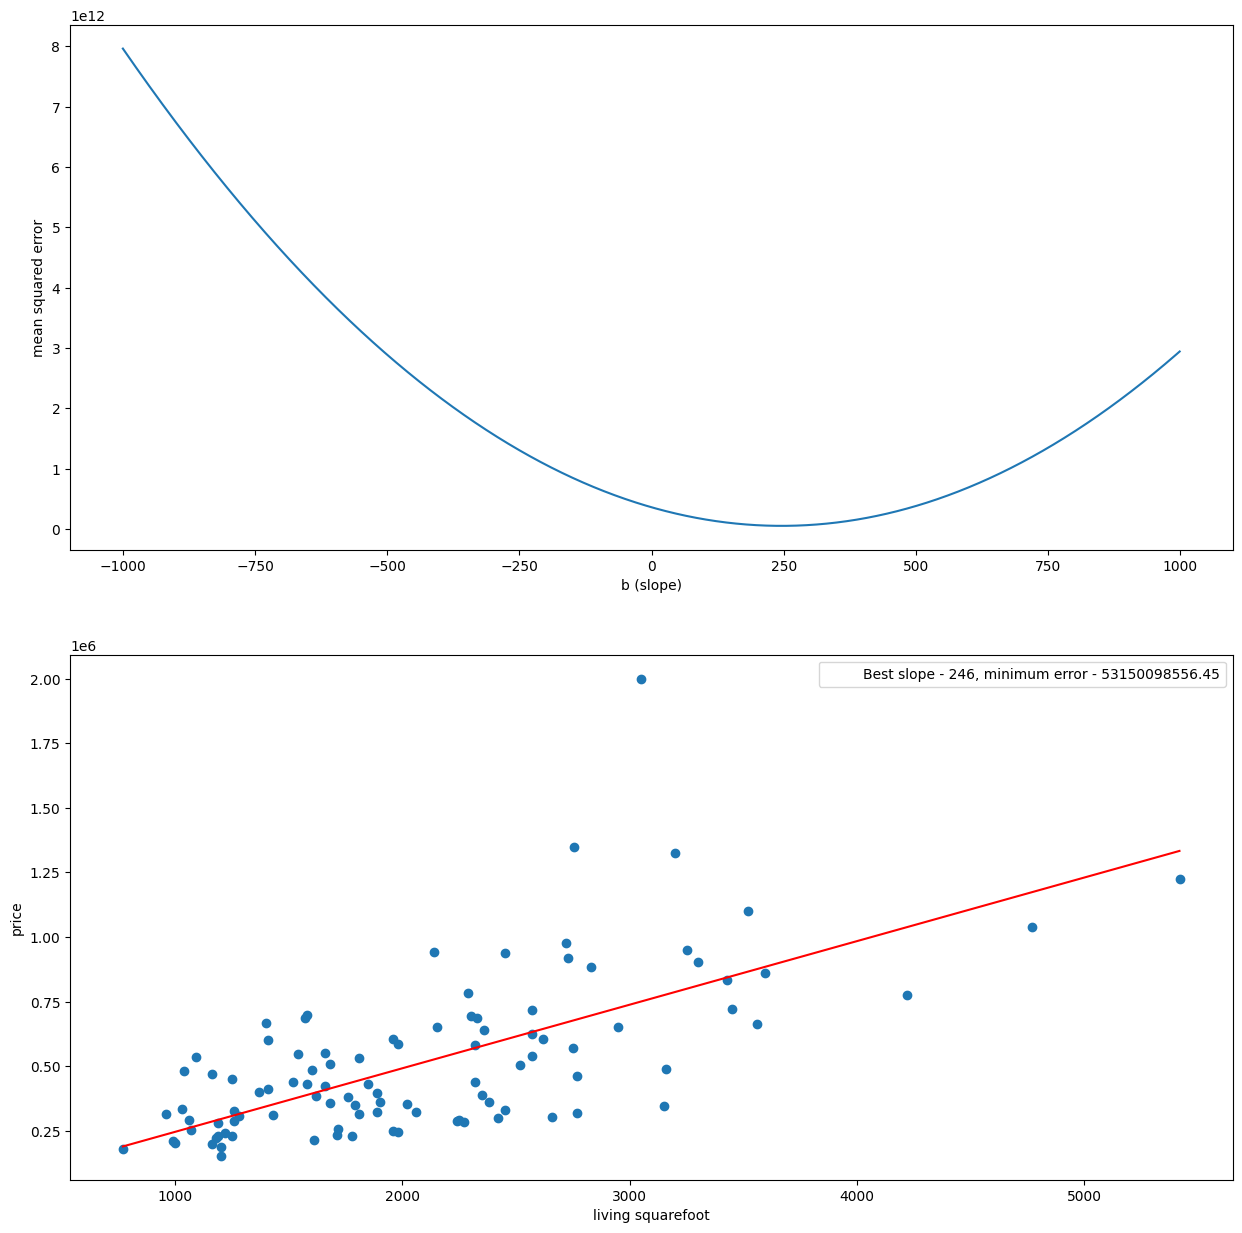

In [524]:
#b)

slope = list(range(-1000,1000))
mean_sqr_err_list = [cost(predict([[i]], X),y) for i in slope]

#plotting
plt.figure(figsize=(15,15))
plt.subplot(2, 1, 1)
plt.plot(slope, mean_sqr_err_list)
plt.xlabel("b (slope)")
plt.ylabel("mean squared error")

#first, we calculate the mean squared error for different slopes (one dimensional vector b is a representation of a line slope)
#on x axis we present possible slopes in the range from -1000 to 1000
#on y axis we present mean squared error for the given slope
#we can notice that we can choose the best slope of our vector b as the minimum of the plotted function

min_error = min(mean_sqr_err_list)
best_slope = slope[np.where(mean_sqr_err_list == min_error)[0][0]]
x_new = np.arange(X.min(), X.max(), 1).reshape(-1,1)

#plotting
plt.subplot(2, 1, 2)
plt.scatter(X, y)
plt.plot(x_new, x_new*best_slope, c="r")
plt.xlabel("living squarefoot")
plt.ylabel("price")
plt.plot([], [], ' ', label="Best slope - 246, minimum error - 53150098556.45")
plt.legend()


# 2. Bias

The line above has limitation of crossing point (0,0). As on our data it doesn't seem harmful, let us check how our model would perform, if all $y$ were shifted by some constant. The interpretation is as follows: the goverment has imposed a new tax in the set amount of 1 million dollar on buying new houses.

As we can see, for the best slope the error has grown almost by the factor of four. In addition we clearly see, that what limits us is indeed the constraint of all lines crossing point $(0,0)$.   

There are two basic solutions of this problem. One of them is centring of the data, that is substracting overall mean from all the values of given feature (or regressand).  

The other is adding bias term, which in this context (different than context discussed during the lectures!) may be understood as constant term in line equation. We simulate adding constant term to result of each prediction by appending artificial feature consisting of ones to **$X$** matrix and additional term to **$b$** vector.

## Exercise 2
a) Add bias column to the **$X$** matrix.  
b) Make the code below compatible with functions that you've created so far.

In [525]:
#a)
#creating a bias column with a size of columns of matrix X (filled with ones)
bias = np.ones(X.shape[0]).reshape(-1,1)
#appending that column to X as a column (defining axis = 1)
X = np.append(X, bias, axis=1)

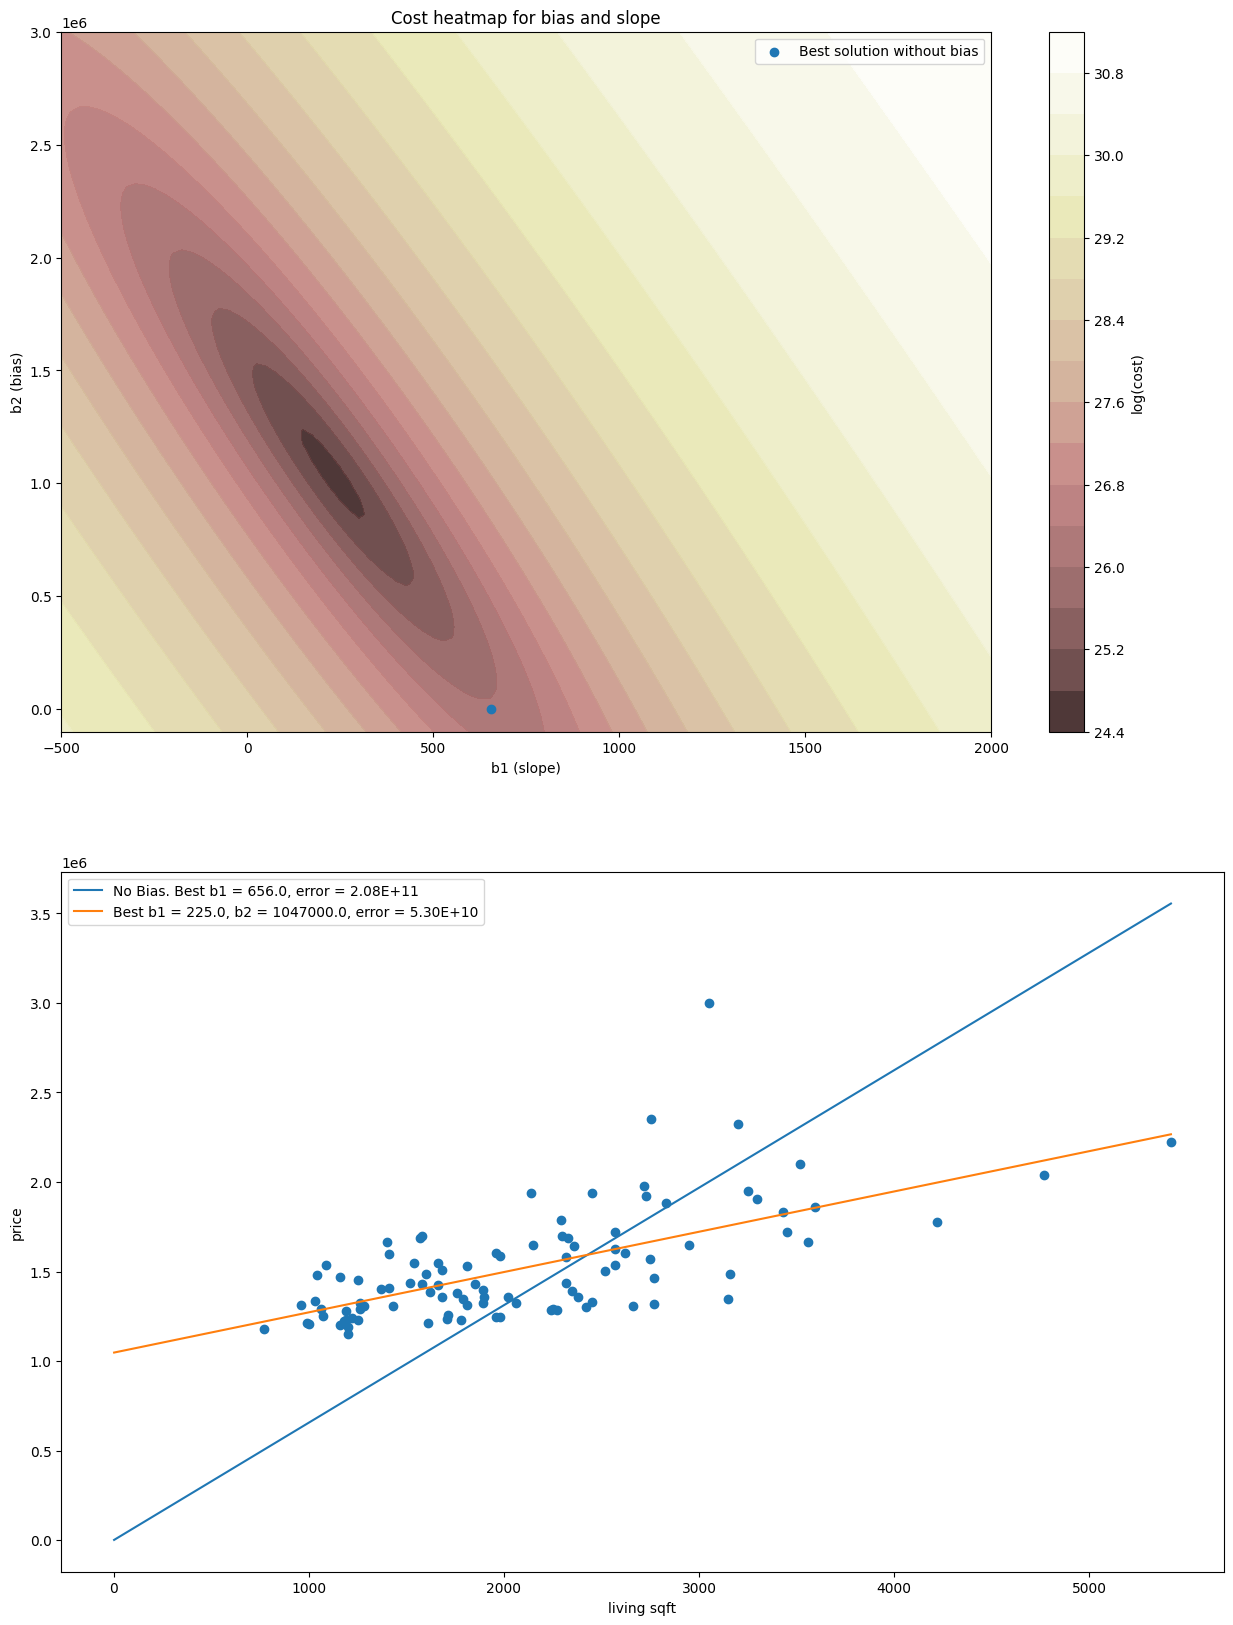

In [526]:
#b)
y_shifted = y+1e6

#No Bias Part
b_arr = [np.array([[b1]]) for b1 in np.linspace(-1000, 1000, num=2001)]
cost_arr = [cost(predict(b, X[:,0].reshape(-1, 1)), y_shifted) for b in b_arr]
best_b1 = b_arr[np.argmin(cost_arr)][0][0]


#Bias Part
nb_of_bs = 101 # compute the cost nb_of_bs times in each dimension
b1 = np.linspace(-500, 2000, num=nb_of_bs) # slope coefficient
b2 = np.linspace(-1e5, 3e6, num=nb_of_bs) # bias
b_x, b_y = np.meshgrid(b1, b2) # generate grid
cost_arr_2d = np.zeros((nb_of_bs, nb_of_bs)) # initialize cost matrix

# Fill the cost matrix for each combination of coefficients
for i in range(nb_of_bs):
    for j in range(nb_of_bs):
        cost_arr_2d[i,j] = cost(predict(np.array([[b_x[i,j]], [b_y[i,j]]]), X) , y_shifted)


plt.figure(figsize=(15,20))

plt.subplot(2,1,1)
plt.title("Cost heatmap for bias and slope")

plt.contourf(b_x, b_y, np.log(cost_arr_2d), 20, alpha=0.9, cmap=cm.pink)
cbar = plt.colorbar()
plt.scatter(best_b1, 0, label = "Best solution without bias")
cbar.ax.set_ylabel('log(cost)')
plt.xlabel("b1 (slope)")
plt.ylabel("b2 (bias)")
plt.legend()

plt.subplot(2,1,2)

plt.scatter(X.T[0], y_shifted)
plt.xlabel("living sqft")
plt.ylabel("price")

x_model = np.linspace(np.min(X), np.max(X), 1000)
y_model = best_b1*x_model
plt.plot(x_model, y_model, label='No Bias. Best b1 = {}, error = {:.2E}'.format(best_b1, cost_arr[np.argmin(cost_arr)]))

best_b1_2d_ind, best_b2_2d_ind = np.unravel_index(cost_arr_2d.argmin(), cost_arr_2d.shape)
best_b1 = b_x[best_b1_2d_ind,best_b2_2d_ind]
best_b2 = b_y[best_b1_2d_ind,best_b2_2d_ind]

y_model = best_b1*x_model + best_b2
plt.plot(x_model, y_model, label='Best b1 = {}, b2 = {}, error = {:.2E}'.format(best_b1, best_b2, cost_arr_2d[best_b1_2d_ind,best_b2_2d_ind]))

plt.legend()

plt.show()

**Adding bias improved error by three orders of magnitude. Not bad!**

# 3. Standardization

In order to improve performance of many machine learning algorithms, the value standardization is applied. It makes the values of each feature in the data have zero-mean and unit-variance. It is achieved by substracting from each value $x$ the overall mean $\bar{x}$, and then dividing it by feature's standard deviation ${\sigma}$:

$$x' = \frac{x - \bar{x}}{\sigma}. $$

It is important to remember, that bias column should not be standardize!

## Exercise 3
a) Implement function standardize(), which standardize the feature matrix and returns it together with two vectors containing original features' means and standard deviations.  
b) Implement function destandardize(), which restores the original data given standardized feature matrix X and vectors containing original features' means and standard deviations.  
c) Plot original $X,y$ data. Then plot it after standardization. Then plot it after destandardisation.

In [527]:
from numpy.ma.core import mean
#a)
def standardize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    standardized_data = (X - mean) / std
    return standardized_data, mean, std
#we standarise data along columns (axis = 0) because we want to calculate the mean and standard deviation for each feature, which corresponds to the columns in dataset

#b)
def destandardize(X, means, sds):
    destandardized_data = X*sds + mean
    return destandardized_data


#short test:
W = [[1,2,3],[2,5,4],[3,4,5],[4,5,7]]
standardize(W)


#Hint: with np.mean and np.std first function is three lines long. The second is one-liner.

(array([[-1.34164079, -1.63299316, -1.18321596],
        [-0.4472136 ,  0.81649658, -0.50709255],
        [ 0.4472136 ,  0.        ,  0.16903085],
        [ 1.34164079,  0.81649658,  1.52127766]]),
 array([2.5 , 4.  , 4.75]),
 array([1.11803399, 1.22474487, 1.47901995]))

Text(0, 0.5, 'price')

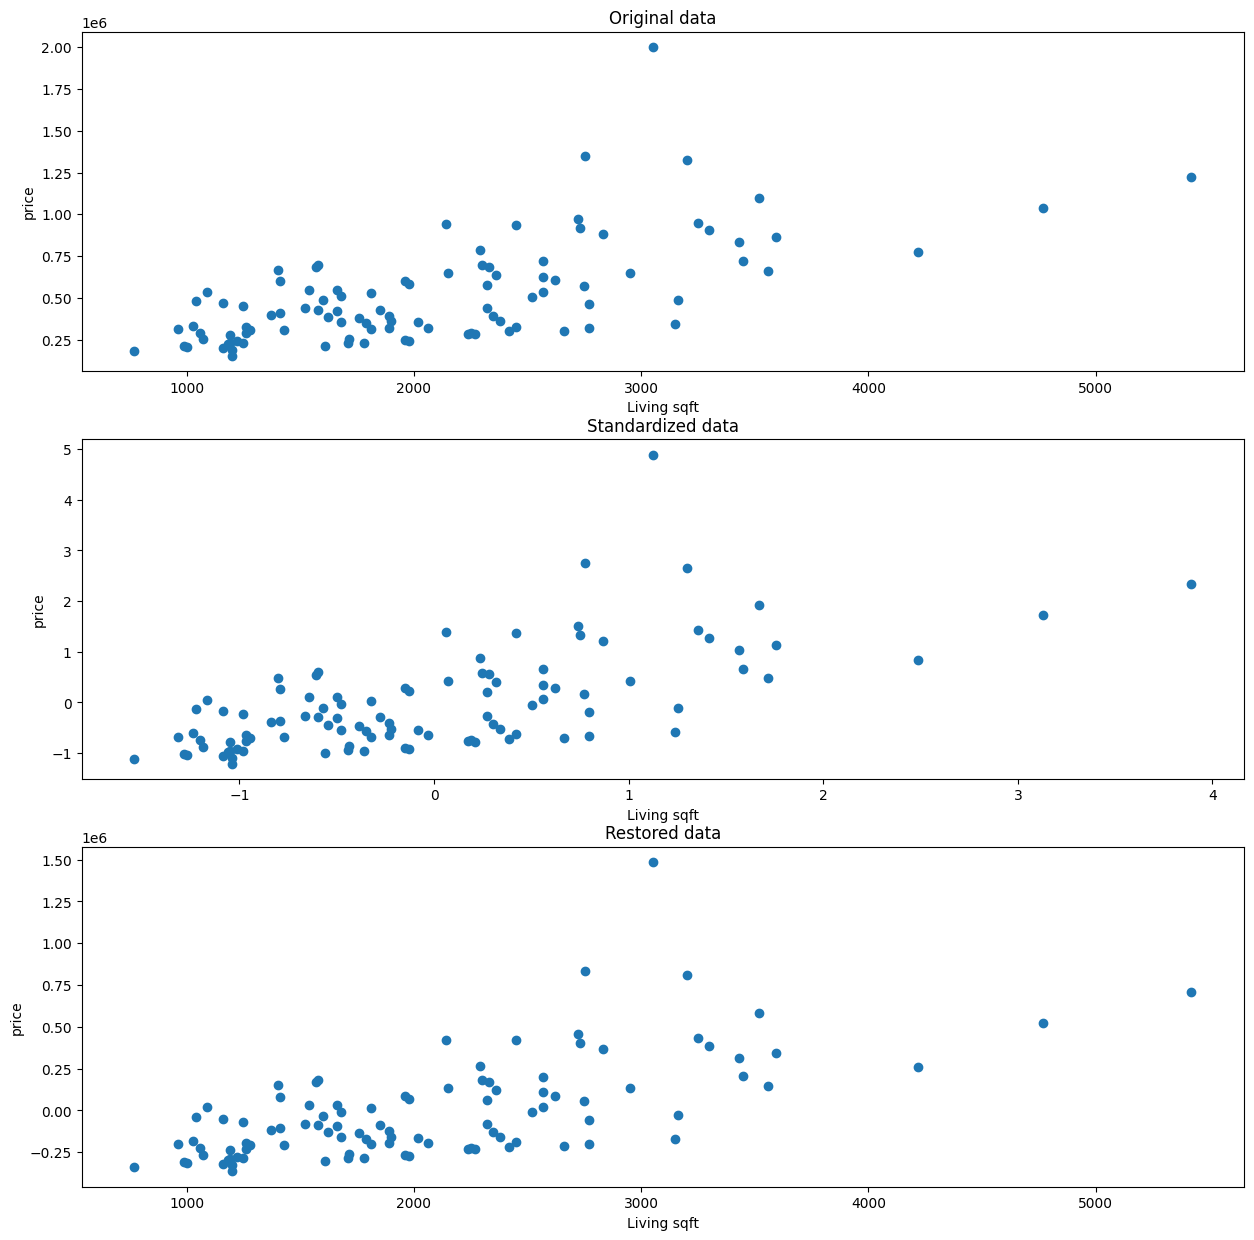

In [528]:
#c)
X = house_df.sqft_living.values.reshape(-1,1)[:100]
y = house_df.price.values.reshape(-1,1)[:100]

plt.figure(figsize=(15,15))
plt.subplot(3, 1, 1)
plt.scatter(X, y)
plt.title("Original data")
plt.xlabel("Living sqft")
plt.ylabel("price")


plt.subplot(3,1,2)
X, mean, sds = standardize(X)
y, meanY, sdsY = standardize(y)
plt.scatter(X, y)
plt.title("Standardized data")
plt.xlabel("Living sqft")
plt.ylabel("price")

plt.subplot(3,1,3)
X = destandardize(X, mean, sds)
y = destandardize(y, meanY, sdsY)
plt.scatter(X, y)
plt.title("Restored data")
plt.xlabel("Living sqft")
plt.ylabel("price")


## 4. Gradient Descent Method

In previous examples we were determining the approximate value of optimal vector **$b$** by finding best arguments from pre-defined grid. This solution is neither fast nor precise. Although in theory it is possible to find vector **$b$** analytically, it requires inversing large matrices, as the close form for **$b$** is $b=(X^\mathsf{T}X)^{-1}X^\mathsf{T}y$.

The other approach is to find approximation of **$b$** is Gradient Descent Method. Let us recall that for function $f: \ R^n \to R$ a gradient

$$\nabla f =  \begin{bmatrix} \frac{\partial f}{\partial x_1} \\ \vdots \\ \frac{\partial f}{\partial x_n} \end{bmatrix}$$

is the direction of the biggest increase of $f$. Using linearity of derivative, $-\nabla f$ is the direction of the biggest decrease. Gradient Descent Method is based on iterative moving in the direction opposite to gradient, and by these means approaching the minimum.

#### GDM step by step:  
1. Choose starting point $x_{0}$ and parameters: *learning rate* and *precision*,
2. Update $x_{i+1} = x_{i} - \nabla f(x_{i})\cdot lr$, where $lr$ is learning rate parameter,
3. If $(|\nabla f(x_{i})| < precision)$, end. If not, go back to point 2.

One of many limitations of GMD may be knowledge of function's gradient. Luckily for us, it is quite easy in case of linear regression with mean square error cost function. We have

$$ \nabla f_{y}(b) = \nabla\dfrac{|Xb−y|^2}{n} = \dfrac{2X^\mathsf{T}(Xb−y)}{n}.  $$

## Exercise 4
a) Create functions: *gradient()* which computes gradient for linear regresion and *gradient_descent_step()* which returns new vector **b** being the result of one GDM step.  

b) Take **$X$** consisting of *sqft_living* together with bias column. Set **$y$** as price. Standardize both **$X$** (without bias) and **$y$**. Plot a heatmap showing dependence of cost function's value on vector **$b$**. Mark first 5 steps of gradient descent with *learning rate* = $0.2$, starting from **$b =  \begin{bmatrix} 3 \\ 2 \end{bmatrix}$**. Experiment with other *learning rates*.  

c) Take **$X$** consisting of *sqft_living* and *sqft_lot*. Set **$y$** as price. Standardize both **$X$** and **$y$**. Plot a heatmap showing dependence of cost function's value on vector **$b$**. Mark first 5 steps of gradient descent with *learning rate* = $0.2$, starting from **$b =  \begin{bmatrix} 3 \\ 1 \end{bmatrix}$**. Experiment with other *learning rates*.  

d) Try to redo above points without standarization. How can you explain such results?


In [529]:
#a)

def gradient(b, X, y):
    return np.dot(2*X.T,(np.dot(X,b))-y)/len(y)


def gradient_descent_step(b, X, y, lr):
    return b - gradient(b, X, y)*lr


#implementing full gradient descent algorithm
def gradient_descent(b, X, y, lr, eps):
    while abs(gradient(b, X, y)) > eps:
      b = gradient_descent_step(b, X, y, lr)
    return b


#short test:
test_b = np.array([[1],[1],[1]])
test_X = np.array([[1,2,3],[2,5,4],[3,4,5],[4,5,7]])
test_y = np.array([[1],[2],[3],[4]])

print(gradient(test_b, test_X, test_y))
print(gradient_descent_step(test_b, test_X, test_y, 0.1))

[[49. ]
 [75.5]
 [90. ]]
[[-3.9 ]
 [-6.55]
 [-8.  ]]


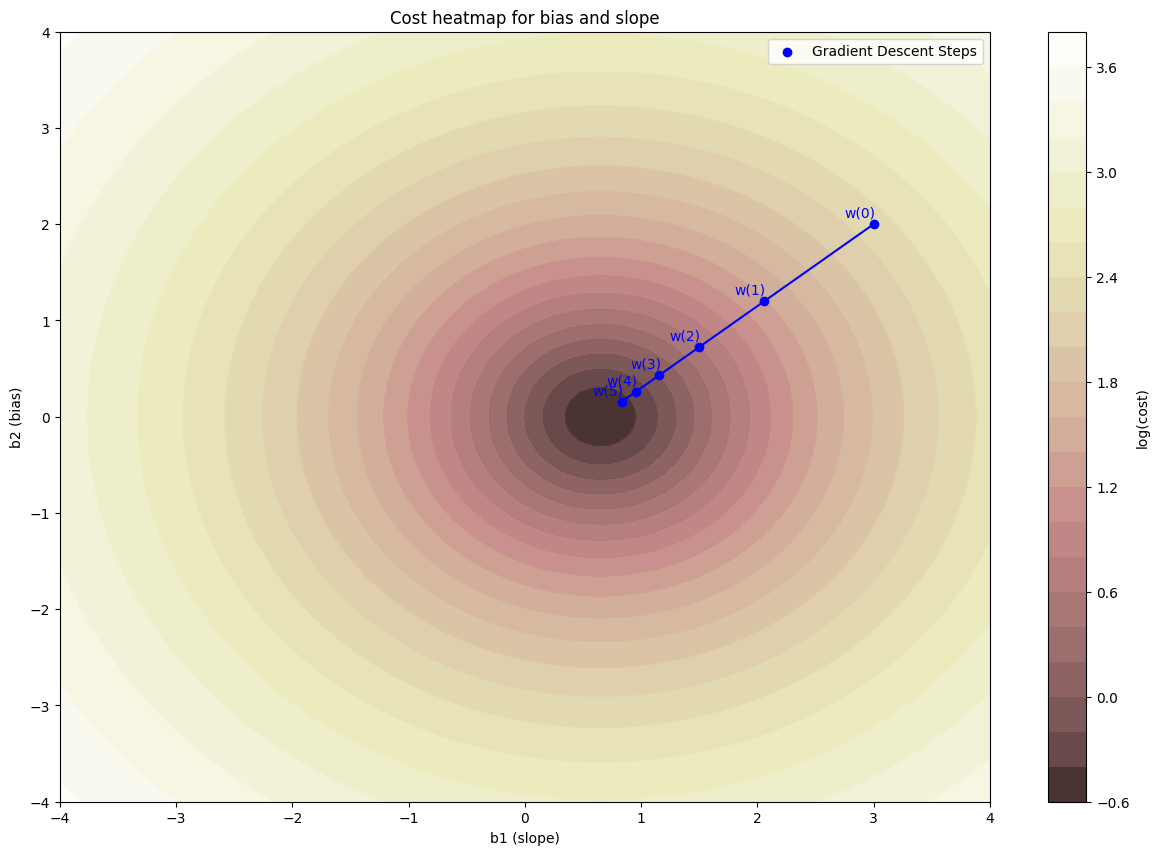

In [530]:
#b)
#standarising X and y
X, mean, sds = standardize(X)
y, meanY, sdsY = standardize(y)

#adding bias to X
bias = np.ones(X.shape[0]).reshape(-1,1)
X = np.append(X, bias, axis=1)

nb_of_bs = 101
b1 = np.linspace(-4, 4, num=nb_of_bs)
b2 = np.linspace(-4, 4, num=nb_of_bs)

#generating grid from b1 and b2
b_x, b_y = np.meshgrid(b1, b2)

#initialising cost matrix
cost_arr_2d = np.zeros((nb_of_bs, nb_of_bs))

# Fill the cost matrix for each combination of coefficients
for i in range(nb_of_bs):
    for j in range(nb_of_bs):
        cost_arr_2d[i,j] = cost(predict(np.array([[b_x[i,j]], [b_y[i,j]]]), X) , y)

#plotting
plt.figure(figsize=(15,10))
plt.title("Cost heatmap for bias and slope")
plt.contourf(b_x, b_y, np.log(cost_arr_2d), 20, alpha=0.9, cmap=cm.pink)
cbar = plt.colorbar()
cbar.ax.set_ylabel('log(cost)')
plt.xlabel("b1 (slope)")
plt.ylabel("b2 (bias)")
plt.legend()

#iterating 5 times through gradient descent argorithm and saving data point
pointListX = []
pointListY = []
b = [[3.], [2.]]

for i in range(6):
  pointListX.append(b[0][0])
  pointListY.append(b[1][0])
  b = gradient_descent_step(b, X, y, 0.2)

#plotting the results
plt.plot(pointListX, pointListY, c="b")
plt.scatter(pointListX, pointListY, label ="Gradient Descent Steps", c="b")
plt.legend()

#adding annotations
labels = ['w(0)', 'w(1)', 'w(2)', 'w(3)', 'w(4)', 'w(5)']
for i, txt in enumerate(labels):
    plt.annotate(txt, (pointListX[i], pointListY[i]),
                 xycoords='data', xytext=(-10, 3),
                 textcoords='offset points',
                 ha="center", va="bottom",
                 color="blue")


#after taking some experiments with other learning rates, i noticed that the bigger lr, the less time it takes for gradient descent to find minimum
#for the 0.4 learning rate gd reaches cost below -0.6 within two steps, while for the 0.05 lr it doesnt go below 1.2 within 5 steps
#overall, this method allows us to reach min in a low amount of steps

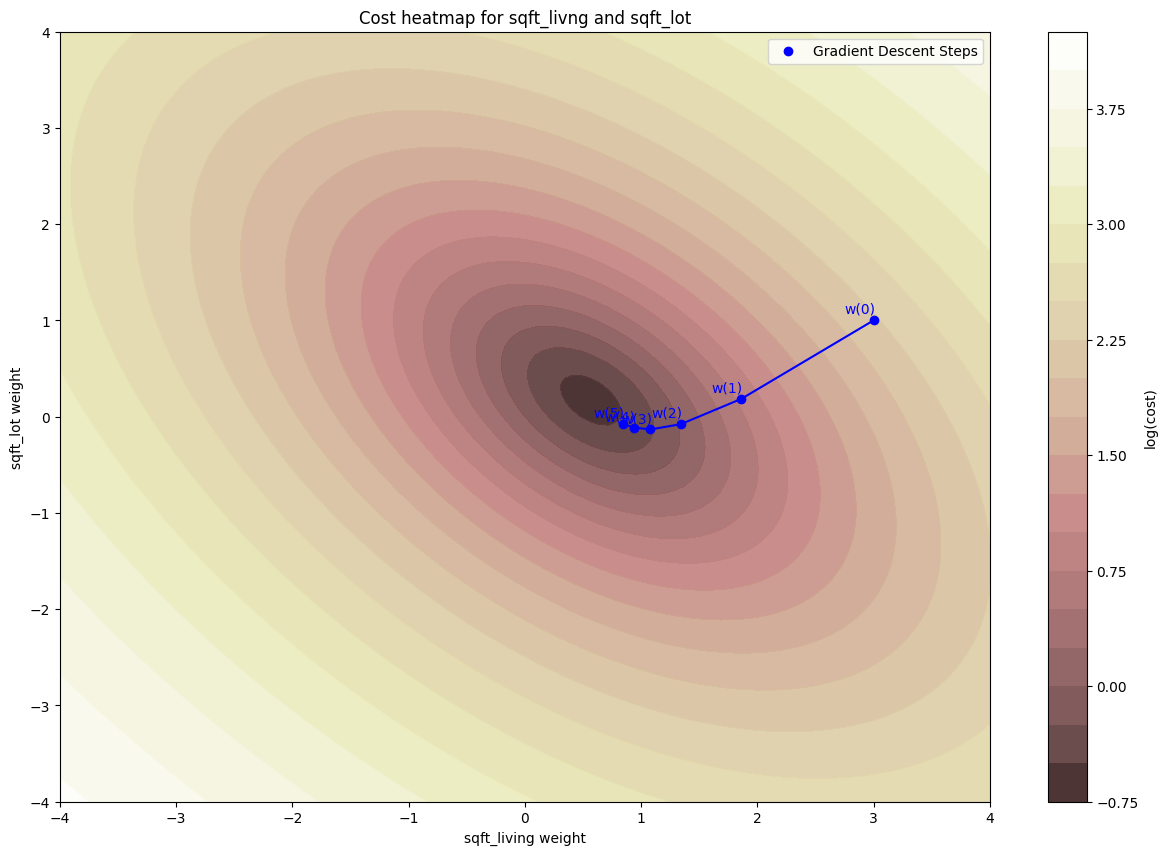

In [531]:
#c)
#standarising X and y
X = house_df[['sqft_living', 'sqft_lot']].values.reshape(-1, 2)[:100]
X, mean, sds = standardize(X)
y, meanY, sdsY = standardize(y)

nb_of_bs = 101
b1 = np.linspace(-4, 4, num=nb_of_bs)
b2 = np.linspace(-4, 4, num=nb_of_bs)

#generating grid from b1 and b2
b_x, b_y = np.meshgrid(b1, b2)

#initialising cost matrix
cost_arr_2d = np.zeros((nb_of_bs, nb_of_bs))

# Fill the cost matrix for each combination of coefficients
for i in range(nb_of_bs):
    for j in range(nb_of_bs):
        cost_arr_2d[i,j] = cost(predict(np.array([[b_x[i,j]], [b_y[i,j]]]), X) , y)

#plotting
plt.figure(figsize=(15,10))
plt.title("Cost heatmap for sqft_livng and sqft_lot")
plt.contourf(b_x, b_y, np.log(cost_arr_2d), 20, alpha=0.9, cmap=cm.pink)
cbar = plt.colorbar()
cbar.ax.set_ylabel('log(cost)')
plt.xlabel("sqft_living weight")
plt.ylabel("sqft_lot weight")
plt.legend()

#iterating 5 times through gradient descent argorithm and saving data point
pointListX = []
pointListY = []
b = [[3.], [1.]]

for i in range(6):
  pointListX.append(b[0][0])
  pointListY.append(b[1][0])
  b = gradient_descent_step(b, X, y, 0.2)

#plotting the results
plt.plot(pointListX, pointListY, c="b")
plt.scatter(pointListX, pointListY, label ="Gradient Descent Steps", c="b")
plt.legend()

#adding annotations
labels = ['w(0)', 'w(1)', 'w(2)', 'w(3)', 'w(4)', 'w(5)']
for i, txt in enumerate(labels):
    plt.annotate(txt, (pointListX[i], pointListY[i]),
                 xycoords='data', xytext=(-10, 3),
                 textcoords='offset points',
                 ha="center", va="bottom",
                 color="blue")

#method allows to find miniumum for many variables
#choosing a good lr is important because it can result either if too many steps needed to reach minimum or "jumping" over it (in the case when lr is too big)

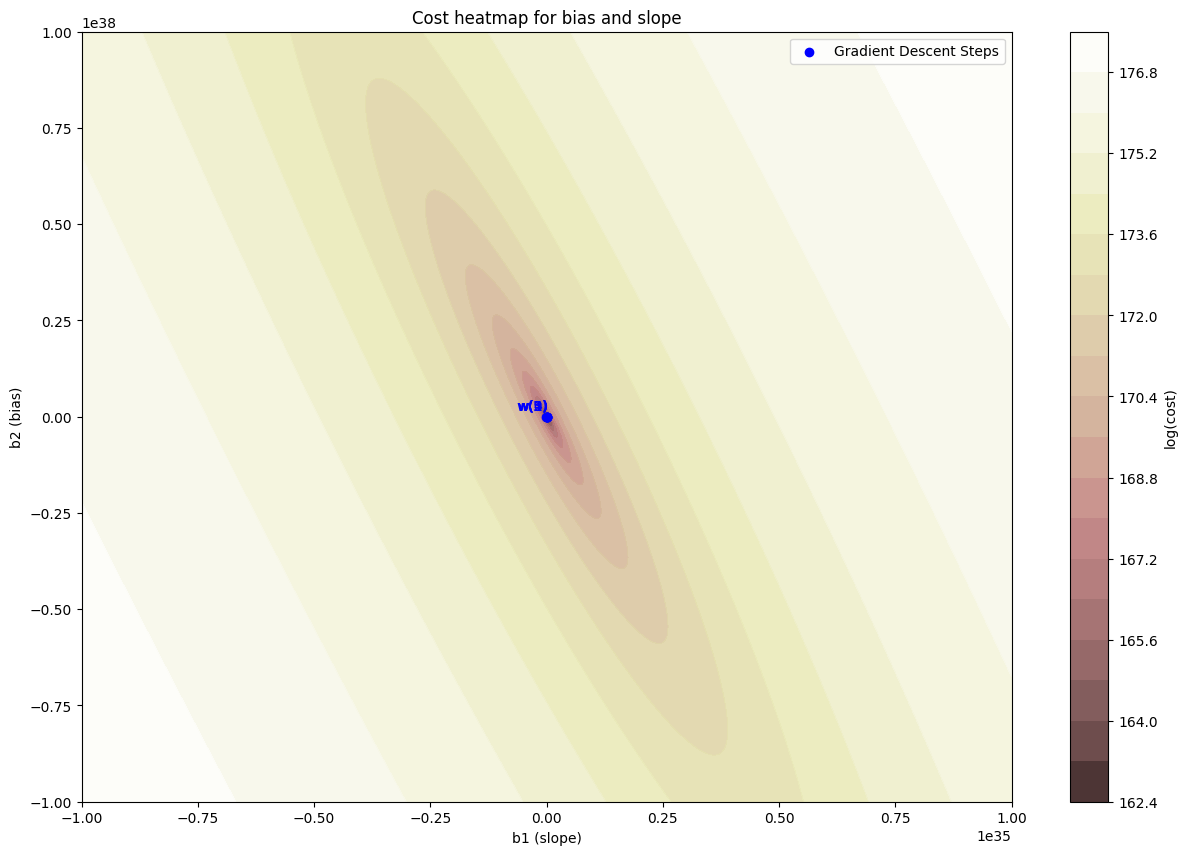

In [532]:
#d)
#### with bias
#adding bias to X
X = house_df.sqft_living.values.reshape(-1,1)[:100]
bias = np.ones(X.shape[0]).reshape(-1,1)
X = np.append(X, bias, axis=1)

nb_of_bs = 500
b1 = np.linspace(-1e35, 1e35, num=nb_of_bs)
b2 = np.linspace(-1e38, 1e38, num=nb_of_bs)

#generating grid from b1 and b2
b_x, b_y = np.meshgrid(b1, b2)

#initialising cost matrix
cost_arr_2d = np.zeros((nb_of_bs, nb_of_bs))

# Fill the cost matrix for each combination of coefficients
for i in range(nb_of_bs):
    for j in range(nb_of_bs):
        cost_arr_2d[i,j] = cost(predict(np.array([[b_x[i,j]], [b_y[i,j]]]), X) , y)

#plotting
plt.figure(figsize=(15,10))
plt.title("Cost heatmap for bias and slope")
plt.contourf(b_x, b_y, np.log(cost_arr_2d), 20, alpha=0.9, cmap=cm.pink)
cbar = plt.colorbar()
cbar.ax.set_ylabel('log(cost)')
plt.xlabel("b1 (slope)")
plt.ylabel("b2 (bias)")
plt.legend()

#iterating 5 times through gradient descent argorithm and saving data point
pointListX = []
pointListY = []
b = [[3.], [2.]]

for i in range(6):
  pointListX.append(b[0][0])
  pointListY.append(b[1][0])
  b = gradient_descent_step(b, X, y, 0.2)

#plotting the results
plt.plot(pointListX, pointListY, c="b")
plt.scatter(pointListX, pointListY, label ="Gradient Descent Steps", c="b")
plt.legend()

#adding annotations
labels = ['w(0)', 'w(1)', 'w(2)', 'w(3)', 'w(4)', 'w(5)']
for i, txt in enumerate(labels):
    plt.annotate(txt, (pointListX[i], pointListY[i]),
                 xycoords='data', xytext=(-10, 3),
                 textcoords='offset points',
                 ha="center", va="bottom",
                 color="blue")


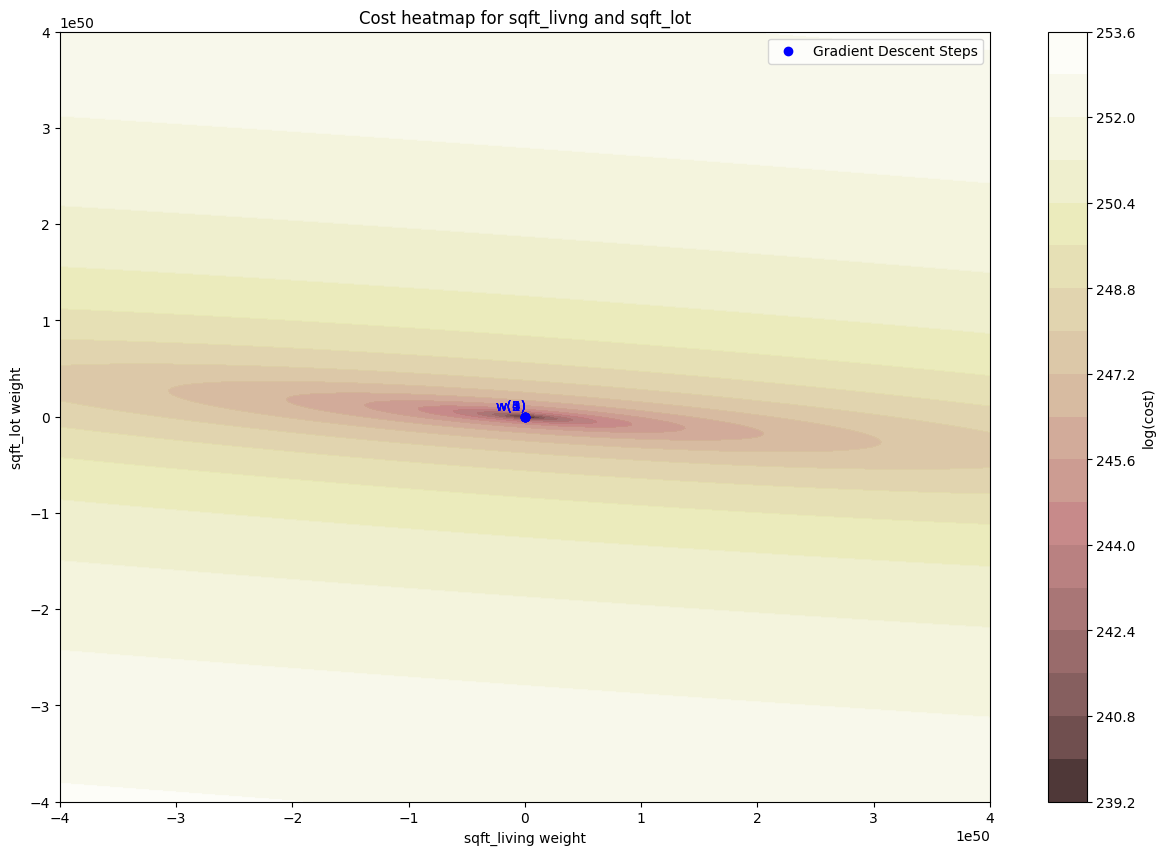

In [533]:
#### with two variables
X = house_df[['sqft_living', 'sqft_lot']].values.reshape(-1, 2)[:100]
nb_of_bs = 500
b1 = np.linspace(-4e50, 4e50, num=nb_of_bs)
b2 = np.linspace(-4e50, 4e50, num=nb_of_bs)

#generating grid from b1 and b2
b_x, b_y = np.meshgrid(b1, b2)

#initialising cost matrix
cost_arr_2d = np.zeros((nb_of_bs, nb_of_bs))

# Fill the cost matrix for each combination of coefficients
for i in range(nb_of_bs):
    for j in range(nb_of_bs):
        cost_arr_2d[i,j] = cost(predict(np.array([[b_x[i,j]], [b_y[i,j]]]), X) , y)

#plotting
plt.figure(figsize=(15,10))
plt.title("Cost heatmap for sqft_livng and sqft_lot")
plt.contourf(b_x, b_y, np.log(cost_arr_2d), 20, alpha=0.9, cmap=cm.pink)
cbar = plt.colorbar()
cbar.ax.set_ylabel('log(cost)')
plt.xlabel("sqft_living weight")
plt.ylabel("sqft_lot weight")
plt.legend()

#iterating 5 times through gradient descent argorithm and saving data point
pointListX = []
pointListY = []
b = [[3.], [1.]]

for i in range(6):
  pointListX.append(b[0][0])
  pointListY.append(b[1][0])
  b = gradient_descent_step(b, X, y, 0.2)

#plotting the results
plt.plot(pointListX, pointListY, c="b")
plt.scatter(pointListX, pointListY, label ="Gradient Descent Steps", c="b")
plt.legend()

#adding annotations
labels = ['w(0)', 'w(1)', 'w(2)', 'w(3)', 'w(4)', 'w(5)']
for i, txt in enumerate(labels):
    plt.annotate(txt, (pointListX[i], pointListY[i]),
                 xycoords='data', xytext=(-10, 3),
                 textcoords='offset points',
                 ha="center", va="bottom",
                 color="blue")

#standardising allows us to present data in more clear way and to extract some exact information
#otherwise, when it comes to big amount of data and small values, it make take some struggle (big amount of space) to present it neatly
#or may cause larger errors while calculating something out of it